<a href="https://colab.research.google.com/github/wrickguha/Malicious-Url-Detection/blob/main/Malware.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Importing Important Libraries**

In [ ]:
import pandas as pd
import itertools
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from lightgbm import LGBMClassifier
import os
import seaborn as sns
from wordcloud import WordCloud

**Dataset**

In [ ]:
df=pd.read_csv('/content/malicious_phish.csv')

In [ ]:
df.head()

,url,type
0,br-icloud.com.br,phishing
1,mp3raid.com/music/krizz_kaliko.html,benign
2,bopsecrets.org/rexroth/cr/1.htm,benign
3,http://www.garage-pirenne.be/index.php?option=...,defacement
4,http://adventure-nicaragua.net/index.php?optio...,defacement


In [ ]:
print(df.shape)
df.head()

(651191, 2)


,url,type
0,br-icloud.com.br,phishing
1,mp3raid.com/music/krizz_kaliko.html,benign
2,bopsecrets.org/rexroth/cr/1.htm,benign
3,http://www.garage-pirenne.be/index.php?option=...,defacement
4,http://adventure-nicaragua.net/index.php?optio...,defacement


In [ ]:
df.type.value_counts()

benign        428103
defacement     96457
phishing       94111
malware        32520
Name: type, dtype: int64

**Plotting WordCloud**

In [ ]:
df_phish=df[df.type=='phishing']
df_malware=df[df.type=='malware']
df_deface=df[df.type=='defacement']
df_benign=df[df.type=='benign']

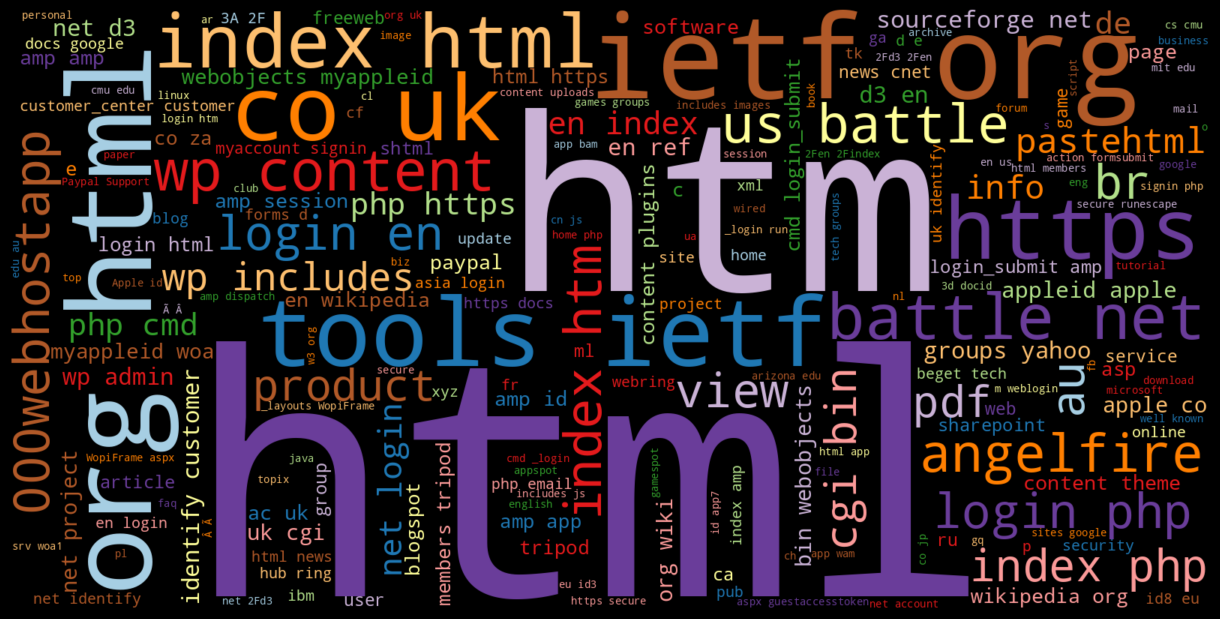

In [ ]:
phish_url=" ".join(i for i in df_phish.url)
wordcloud = WordCloud(width=1600, height=800, colormap='Paired').generate(phish_url)
plt.figure(figsize=(12,14),facecolor='k')
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

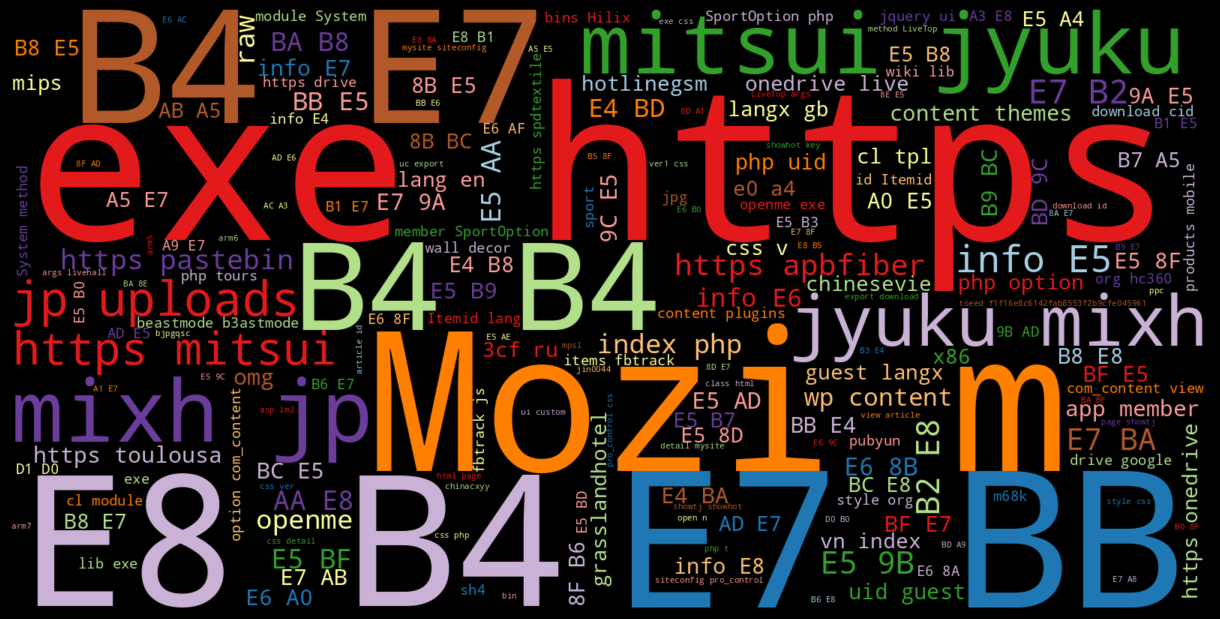

In [ ]:
malware_url=" ".join(i for i in df_malware.url)
wordcloud= WordCloud(width=1600, height=800, colormap='Paired').generate(malware_url)
plt.figure(figsize=(12,14),facecolor='k')
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

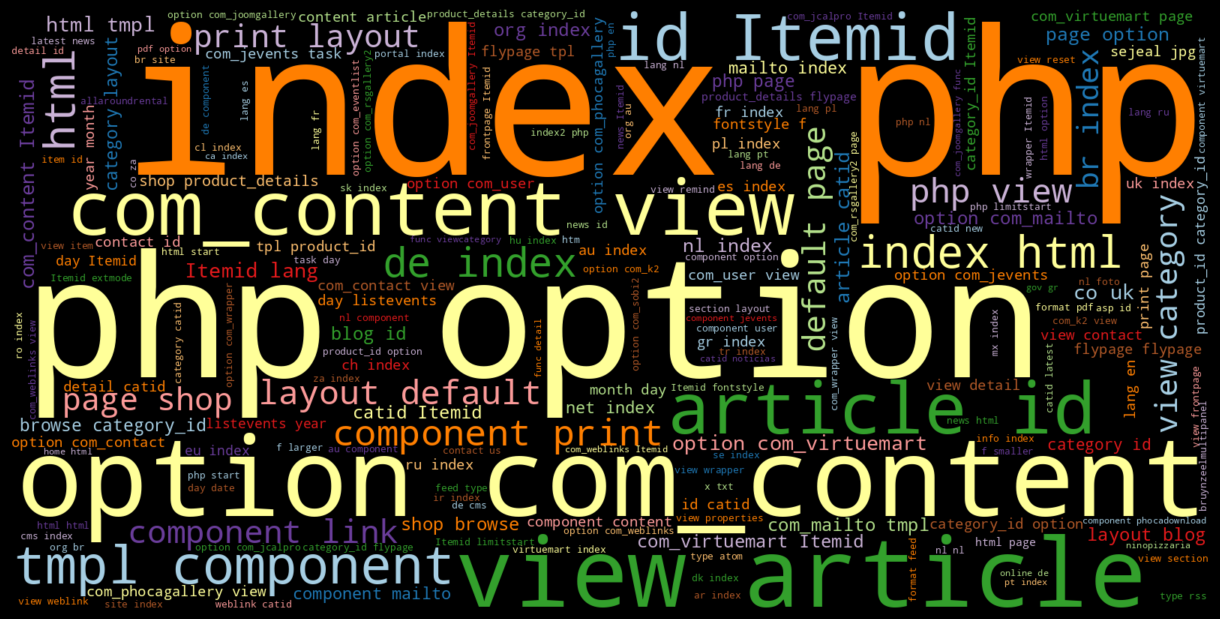

In [ ]:
deface_url=" ".join(i for i in df_deface.url)
wordcloud=WordCloud(width=1600, height=800, colormap='Paired').generate(deface_url)
plt.figure( figsize=(12,14),facecolor='k')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

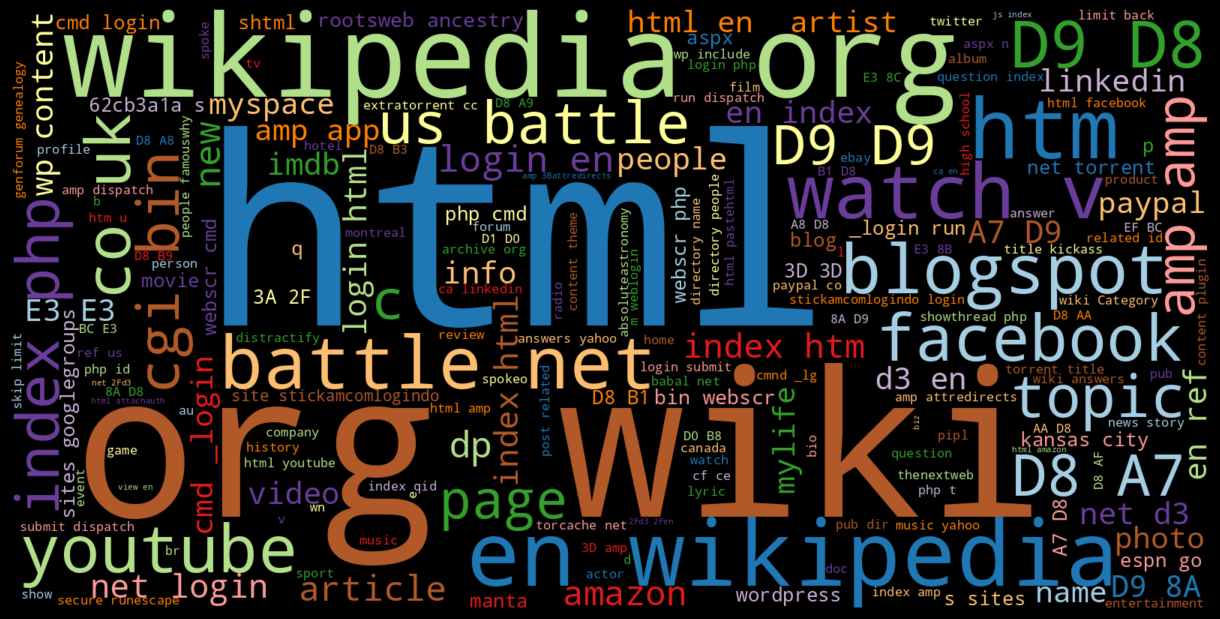

In [ ]:
benign_url=" ".join( i for i in df_benign.url)
wordcloud= WordCloud(width=1600, height=800, colormap='Paired').generate(benign_url)
plt.figure(figsize=(12,14),facecolor='k')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

**Feature Engineering**

In [ ]:
import re
def having_ip_address(url):
  match= re.search('(([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.'
        '([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\/)|'  # IPv4
        '((0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\/)' # IPv4 in hexadecimal
        '(?:[a-fA-F0-9]{1,4}:){7}[a-fA-F0-9]{1,4}', url) #IPv6
  if match:
    return 1
  else:
    return 0
df['use_of_ip']=df['url'].apply(lambda i: having_ip_address(i))

In [ ]:
from urllib.parse import urlparse
def abnormal_url(url):
  hostname=urlparse(url).hostname
  hostname=str(hostname)
  match=re.search(hostname,url)
  if match:
    return 1
  else:
    return 0
df['abnormal_url']=df['url'].apply(lambda i:abnormal_url(i))

In [ ]:
from googlesearch import search

In [ ]:
def google_index(url):
  site=search(url,5)
  return 1 if site else 0
df['google_index']=df['url'].apply(lambda i:google_index(i))

In [ ]:
def count_dot(url):
  count_dot=url.count('.')
  return count_dot
df['count.']=df['url'].apply(lambda i: count_dot(i))
df.head()

,url,type,use_of_ip,abnormal_url,google_index,count.
0,br-icloud.com.br,phishing,0,0,1,2
1,mp3raid.com/music/krizz_kaliko.html,benign,0,0,1,2
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,0,1,2
3,http://www.garage-pirenne.be/index.php?option=...,defacement,0,1,1,3
4,http://adventure-nicaragua.net/index.php?optio...,defacement,0,1,1,2


In [ ]:
def count_www(url):
  url.count('www')
  return url.count('www')
df['count-www']= df['url'].apply(lambda i: count_www(i))

def count_atrate(url):
  return url.count('@')
df['count@']=df['url'].apply(lambda i:count_atrate(i))

def no_of_dir(url):
  urldir=urlparse(url).path
  return urldir.count('/')
df['count_dir']=df['url'].apply(lambda i: no_of_dir(i))

def no_of_embed(url):
  urldir=urlparse(url).path
  return urldir.count('//')
df['count_embed_domain']=df['url'].apply(lambda i: no_of_embed(i))

def shortening_service(url):
  match=re.search('bit\.ly|goo\.gl|shorte\.st|go2l\.ink|x\.co|ow\.ly|t\.co|tinyurl|tr\.im|is\.gd|cli\.gs|'
                      'yfrog\.com|migre\.me|ff\.im|tiny\.cc|url4\.eu|twit\.ac|su\.pr|twurl\.nl|snipurl\.com|'
                      'short\.to|BudURL\.com|ping\.fm|post\.ly|Just\.as|bkite\.com|snipr\.com|fic\.kr|loopt\.us|'
                      'doiop\.com|short\.ie|kl\.am|wp\.me|rubyurl\.com|om\.ly|to\.ly|bit\.do|t\.co|lnkd\.in|'
                      'db\.tt|qr\.ae|adf\.ly|goo\.gl|bitly\.com|cur\.lv|tinyurl\.com|ow\.ly|bit\.ly|ity\.im|'
                      'q\.gs|is\.gd|po\.st|bc\.vc|twitthis\.com|u\.to|j\.mp|buzurl\.com|cutt\.us|u\.bb|yourls\.org|'
                      'x\.co|prettylinkpro\.com|scrnch\.me|filoops\.info|vzturl\.com|qr\.net|1url\.com|tweez\.me|v\.gd|'
                      'tr\.im|link\.zip\.net',
                      url)
  if match:
    return 1
  else:
     return 0

df['short_url']=df['url'].apply(lambda i: shortening_service(i))

In [ ]:
def count_https(url):
  return url.count('https')
df['count-https']=df['url'].apply(lambda i : count_https(i))

def count_http(url):
  return url.count('http')
df['count-http']=df['url'].apply(lambda i: count_http(i))

In [ ]:
def count_per(url):
  return url.count('%')
df['count%']= df['url'].apply(lambda i : count_per(i))

def count_ques(url):
  return url.count('?')
df['count?']= df['url'].apply(lambda i : count_ques(i))

def count_hyphen(url):
  return url.count('-')
df['count-']= df['url'].apply(lambda i : count_hyphen(i))

def count_equal(url):
  return url.count('=')
df['count=']= df['url'].apply(lambda i: count_equal(i))

def url_length(url):
  return len(str(url))

df['url_length']= df['url'].apply(lambda i: url_length(i))

def hostname_length(url):
  return len(urlparse(url).netloc)
df['hostname_length']= df['url'].apply(lambda i: hostname_length(i))

df.head()

def suspicious_words(url):
  match=re.search('PayPal|login|signup|bank|account|update|free|lucky|service|bonus|ebayisapi|webscr',url)

  if match:
    return 1
  else:
    return 0

df['sus_url']=df['url'].apply(lambda i: suspicious_words(i))

def digit_count(url):
  digits=0
  for i in url:
    if i.isnumeric():
      digits=digits+1
  return digits

df['count_digits']=df['url'].apply(lambda i:digit_count(i))

def letter_count(url):
  letters=0
  for i in url:
    if i.isalpha():
      letters=letters+1
  return letters

df['count-letters']=df['url'].apply(lambda i: letter_count(i))
df.head()

,url,type,use_of_ip,abnormal_url,google_index,count.,count-www,count@,count_dir,count_embed_domain,...,count-http,count%,count?,count-,count=,url_length,hostname_length,sus_url,count_digits,count-letters
0,br-icloud.com.br,phishing,0,0,1,2,0,0,0,0,...,0,0,0,1,0,16,0,0,0,13
1,mp3raid.com/music/krizz_kaliko.html,benign,0,0,1,2,0,0,2,0,...,0,0,0,0,0,35,0,0,1,29
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,0,1,2,0,0,3,0,...,0,0,0,0,0,31,0,0,1,25
3,http://www.garage-pirenne.be/index.php?option=...,defacement,0,1,1,3,1,0,1,0,...,1,0,1,1,4,88,21,0,7,63
4,http://adventure-nicaragua.net/index.php?optio...,defacement,0,1,1,2,0,0,1,0,...,1,0,1,1,3,235,23,0,22,199


In [ ]:
pip install tld

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 263.8/263.8 kB 4.7 MB/s eta 0:00:00


In [ ]:
from urllib.parse import urlparse
from tld import get_tld
import os.path
def fd_length(url):
  urlpath=urlparse(url).path
  try:
    return len(urlpath.split('/')[1])
  except:
    return 0

df['fd_length']=df['url'].apply(lambda i: fd_length(i))

df['tld']=df['url'].apply(lambda i: get_tld(i,fail_silently=True))

def tld_length(tld):
  try:
    return len(tld)
  except:
    return -1
df['tld_length']=df['tld'].apply(lambda i:tld_length(i))

In [ ]:
df = df.drop("tld",1)

<ipython-input-21-beaedf415f7f>:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df = df.drop("tld",1)


In [ ]:
df.columns

Index(['url', 'type', 'use_of_ip', 'abnormal_url', 'google_index', 'count.',
       'count-www', 'count@', 'count_dir', 'count_embed_domain', 'short_url',
       'count-https', 'count-http', 'count%', 'count?', 'count-', 'count=',
       'url_length', 'hostname_length', 'sus_url', 'count_digits',
       'count-letters', 'fd_length', 'tld_length'],
      dtype='object')

In [ ]:
df['type'].value_counts()

benign        428103
defacement     96457
phishing       94111
malware        32520
Name: type, dtype: int64

In [ ]:
print(df.head())
print(df.columns)

                                                 url        type  use_of_ip  \
0                                   br-icloud.com.br    phishing          0   
1                mp3raid.com/music/krizz_kaliko.html      benign          0   
2                    bopsecrets.org/rexroth/cr/1.htm      benign          0   
3  http://www.garage-pirenne.be/index.php?option=...  defacement          0   
4  http://adventure-nicaragua.net/index.php?optio...  defacement          0   

   abnormal_url  google_index  count.  count-www  count@  count_dir  \
0             0             1       2          0       0          0   
1             0             1       2          0       0          2   
2             0             1       2          0       0          3   
3             1             1       3          1       0          1   
4             1             1       2          0       0          1   

   count_embed_domain  ...  count?  count-  count=  url_length  \
0                   0  ...      

DISTRIBUTION OF USE_OF_IP

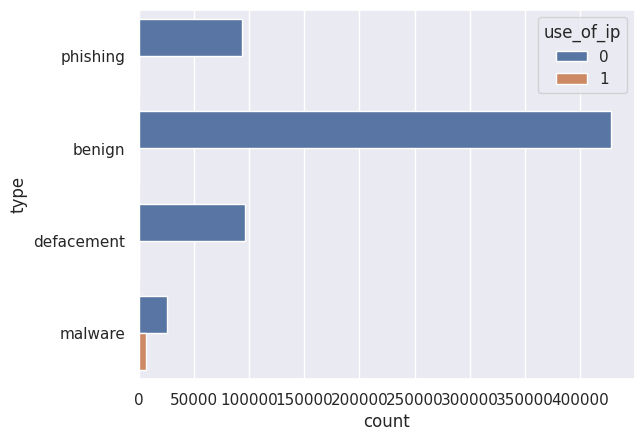

In [ ]:
import seaborn as sns
sns.set(style="darkgrid")
ax = sns.countplot(y="type", data=df, hue="use_of_ip")

DISTRIBUTION OF ABNORMAL URL

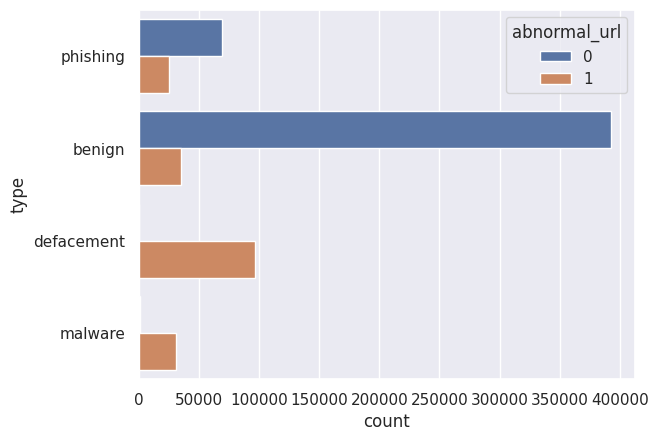

In [ ]:
  sns.set(style="darkgrid")
  ax=sns.countplot(y="type",data=df,hue="abnormal_url")

DISTRIBUTION OF GOOGLE INDEX

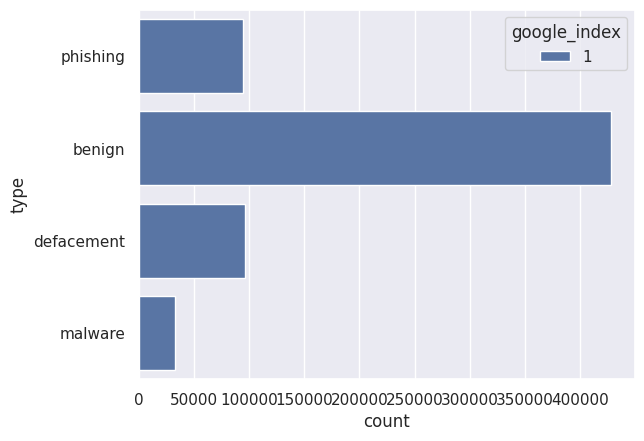

In [ ]:
sns.set(style="darkgrid")
ax=sns.countplot(y="type", data=df, hue="google_index")

DISTRIBUTION OF SHORT URL

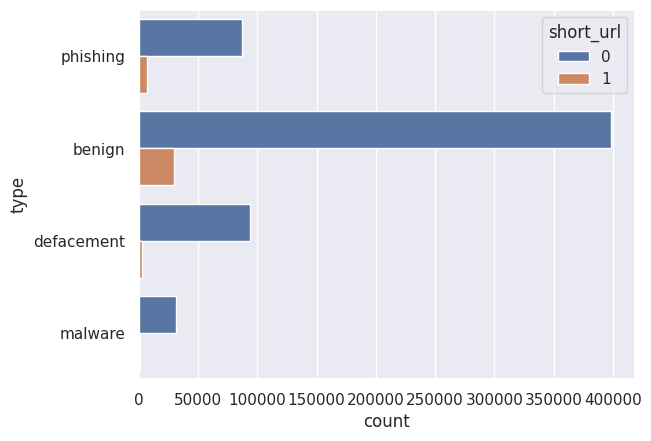

In [ ]:
sns.set(style="darkgrid")
ax=sns.countplot(y="type", data=df, hue="short_url")

DISTRIBUTION OF SUSPICIOUS URL

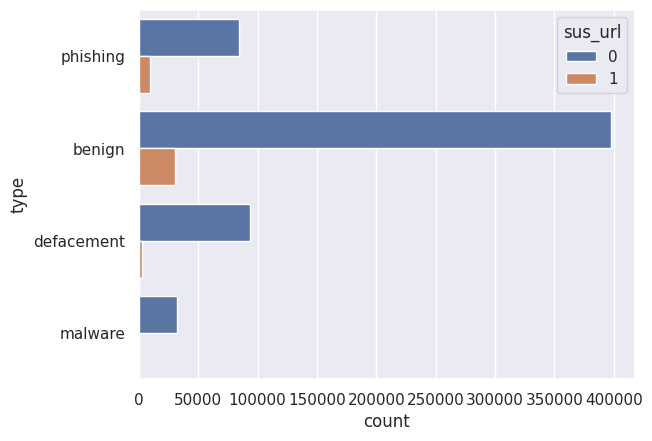

In [ ]:
sns.set(style="darkgrid")
ax=sns.countplot(y="type", data=df, hue="sus_url")

DISTRIBUTION OF COUNT OF [.] DOT

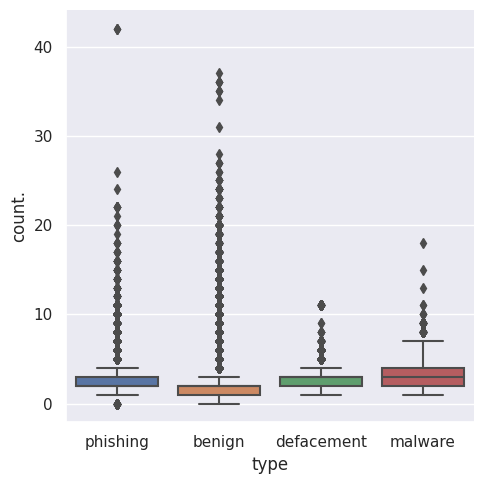

In [ ]:
sns.set(style="darkgrid")
ax=sns.catplot(x="type", y="count.", kind="box",data=df)

DISTRIBUTION OF COUNT-WWW

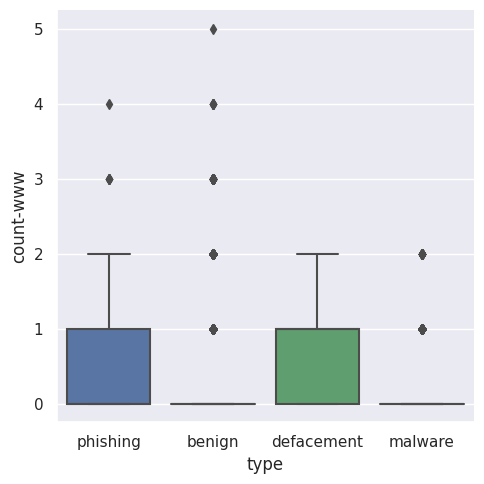

In [ ]:
sns.set(style="darkgrid")
ax=sns.catplot(x="type", y="count-www", kind="box", data=df)

DISTRIBUTION OF COUNT@

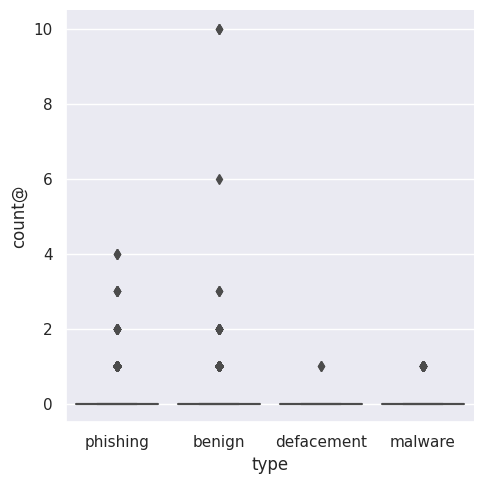

In [ ]:
sns.set(style="darkgrid")
ax=sns.catplot(x="type", y="count@", kind="box", data=df)

DISTRIBUTION OF COUNT_DIR

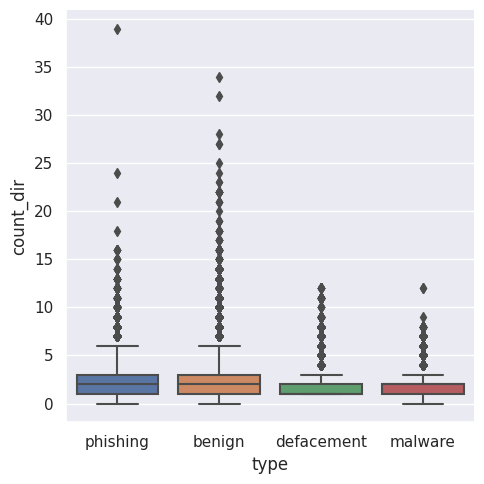

In [ ]:
sns.set(style="darkgrid")
ax=sns.catplot(x="type", y="count_dir", kind="box", data=df)

DISTRIBUTION OF HOSTNAME LENGTH

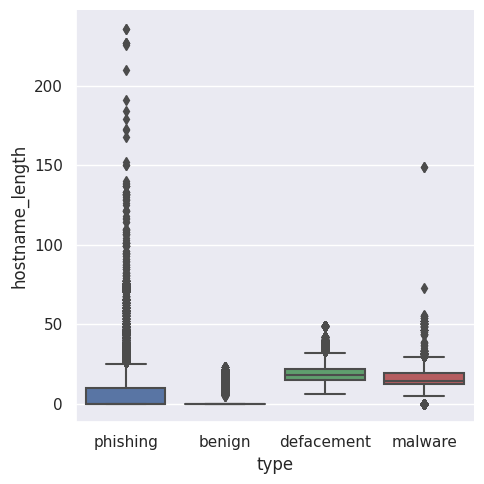

In [ ]:
sns.set(style="darkgrid")
ax = sns.catplot(x="type", y="hostname_length", kind="box", data=df)

DISTRIBUTION OF FIRST DIRECTORY LENGTH

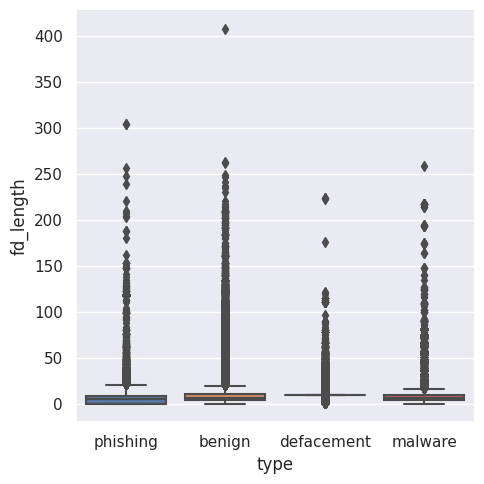

In [ ]:
sns.set(style="darkgrid")
ax= sns.catplot(x="type", y="fd_length", kind="box", data=df)

DISTRIBUTION OF TOP LEVEL DOMAIN LENGTH

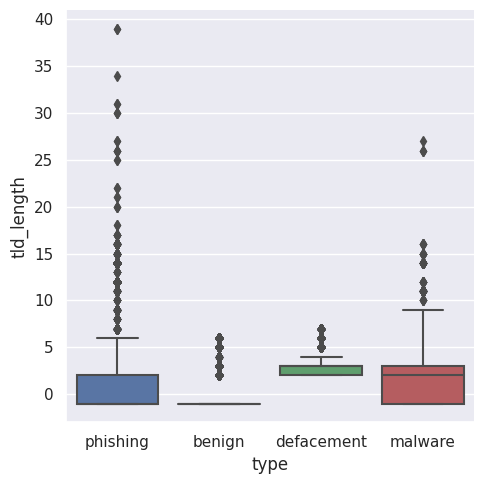

In [ ]:
sns.set(style="darkgrid")
ax=sns.catplot(x="type", y="tld_length", kind="box", data=df)

TARGET ENCODING

In [ ]:
from sklearn.preprocessing import LabelEncoder

lb_make= LabelEncoder()
df["type_code"]=lb_make.fit_transform(df["type"])
df["type_code"].value_counts()

0    428103
1     96457
3     94111
2     32520
Name: type_code, dtype: int64

CREATION OF FEATURE & TARGET

In [ ]:
X= df[['use_of_ip', 'abnormal_url', 'google_index', 'count.',
       'count-www', 'count@', 'count_dir', 'count_embed_domain', 'short_url',
       'count-https', 'count-http', 'count%', 'count?', 'count-', 'count=',
       'url_length', 'hostname_length', 'sus_url', 'count_digits',
       'count-letters', 'fd_length', 'tld_length']]
y=df['type_code']

In [ ]:
X.head()

,use_of_ip,abnormal_url,google_index,count.,count-www,count@,count_dir,count_embed_domain,short_url,count-https,...,count?,count-,count=,url_length,hostname_length,sus_url,count_digits,count-letters,fd_length,tld_length
0,0,0,1,2,0,0,0,0,0,0,...,0,1,0,16,0,0,0,13,0,-1
1,0,0,1,2,0,0,2,0,0,0,...,0,0,0,35,0,0,1,29,5,-1
2,0,0,1,2,0,0,3,0,0,0,...,0,0,0,31,0,0,1,25,7,-1
3,0,1,1,3,1,0,1,0,0,0,...,1,1,4,88,21,0,7,63,9,2
4,0,1,1,2,0,0,1,0,0,0,...,1,1,3,235,23,0,22,199,9,3


In [ ]:
X.columns

Index(['use_of_ip', 'abnormal_url', 'google_index', 'count.', 'count-www',
       'count@', 'count_dir', 'count_embed_domain', 'short_url', 'count-https',
       'count-http', 'count%', 'count?', 'count-', 'count=', 'url_length',
       'hostname_length', 'sus_url', 'count_digits', 'count-letters',
       'fd_length', 'tld_length'],
      dtype='object')

TRAIN TEST SPLIT

In [ ]:
X_train,X_test,y_train,y_test= train_test_split(X,y,stratify=y,test_size=0.2,shuffle=True,random_state=5)

MODEL BUILDING

RANDOM FOREST CLASSIFIER

In [ ]:
import sklearn.metrics as metrics
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score


In [ ]:
from sklearn.ensemble import RandomForestClassifier
rf=RandomForestClassifier(n_estimators=100,max_features='sqrt')
rf.fit(X_train,y_train)
y_pred_rf=rf.predict(X_test)
print(classification_report(y_test,y_pred_rf,target_names=['benign', 'defacement','phishing','malware']))
score = metrics.accuracy_score (y_test, y_pred_rf)
print("accuracy:   %0.3f" % score)

              precision    recall  f1-score   support

      benign       0.97      0.98      0.98     85621
  defacement       0.98      0.99      0.99     19292
    phishing       0.99      0.94      0.96      6504
     malware       0.91      0.86      0.88     18822

    accuracy                           0.97    130239
   macro avg       0.96      0.95      0.95    130239
weighted avg       0.97      0.97      0.97    130239

accuracy:   0.966


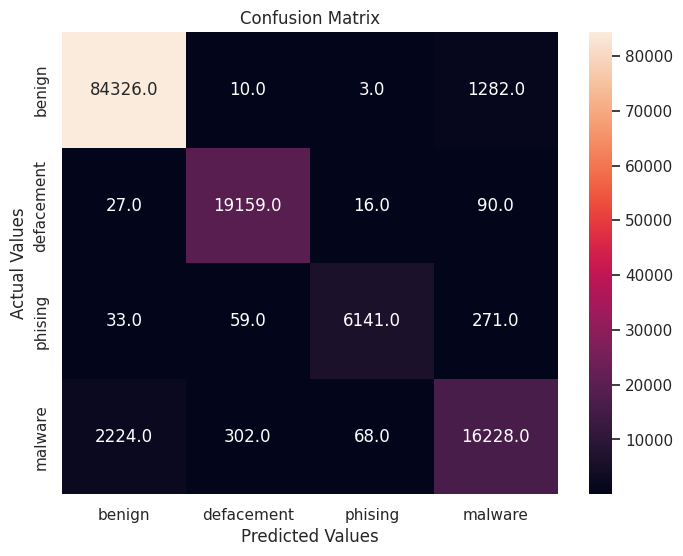

In [ ]:
cm=confusion_matrix(y_test, y_pred_rf)
cm_df=pd.DataFrame(cm,
                   index=['benign','defacement','phising','malware'],
                   columns=['benign','defacement','phising','malware'])
plt.figure(figsize=(8,6))
sns.heatmap(cm_df, annot=True, fmt=".1f")
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

<Axes: >

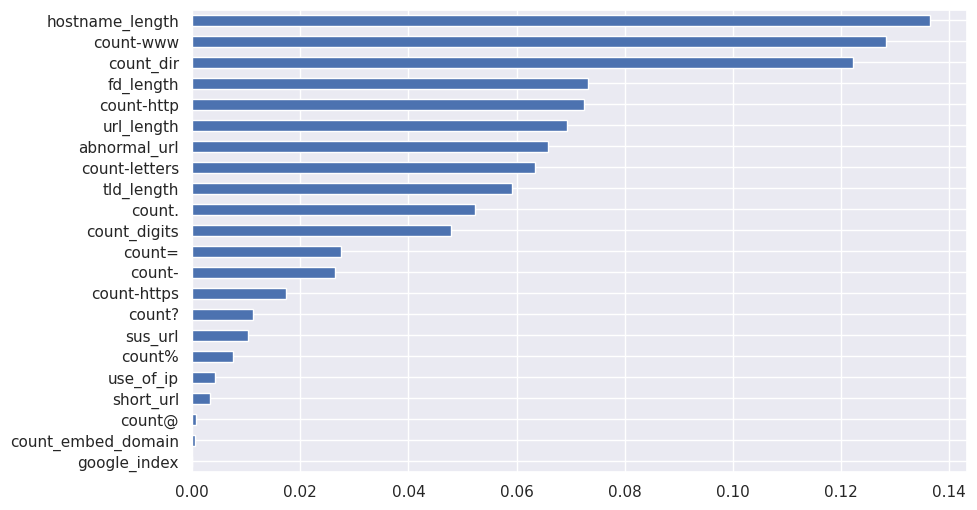

In [ ]:
feat_importances=pd.Series(rf.feature_importances_,index=X_train.columns)
feat_importances.sort_values().plot(kind="barh", figsize=(10,6))

LIGHT GBM CLASSIFIER

In [ ]:
lgb = LGBMClassifier(objective='multiclass',boosting_type= 'gbdt',n_jobs = 5,
          silent = True, random_state=5)
LGB_C = lgb.fit(X_train, y_train)


y_pred_lgb = LGB_C.predict(X_test)
print(classification_report(y_test,y_pred_lgb,target_names=['benign', 'defacement','phishing','malware']))

score = metrics.accuracy_score(y_test, y_pred_lgb)
print("accuracy:   %0.3f" % score)

[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.129881 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1158
[LightGBM] [Info] Number of data points in the train set: 520952, number of used features: 21
[LightGBM] [Info] Start training from score -0.419439
[LightGBM] [Info] Start training from score -1.909712
[LightGBM] [Info] Start training from score -2.996946
[LightGBM] [Info] Start training from score -1.934324
[LightGBM] [Warning] Unknown parameter: silent
              precision    recall  f1-score   support

      benign       0.97      0.99      0.98     85621
  defacement       0.96      0.99      0.98     19292
    phishing       0.97      0.91      0.94      6504
     malware       0.90      0.82      0.86     18822

    accuracy     

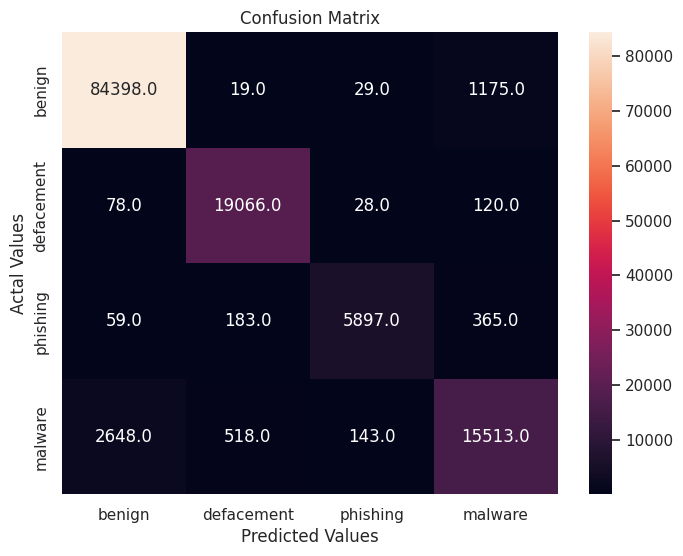

In [ ]:
cm = confusion_matrix(y_test, y_pred_lgb)
cm_df = pd.DataFrame(cm,
                     index = ['benign', 'defacement','phishing','malware'],
                     columns = ['benign', 'defacement','phishing','malware'])
plt.figure(figsize=(8,6))
sns.heatmap(cm_df, annot=True,fmt=".1f")
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

<Axes: >

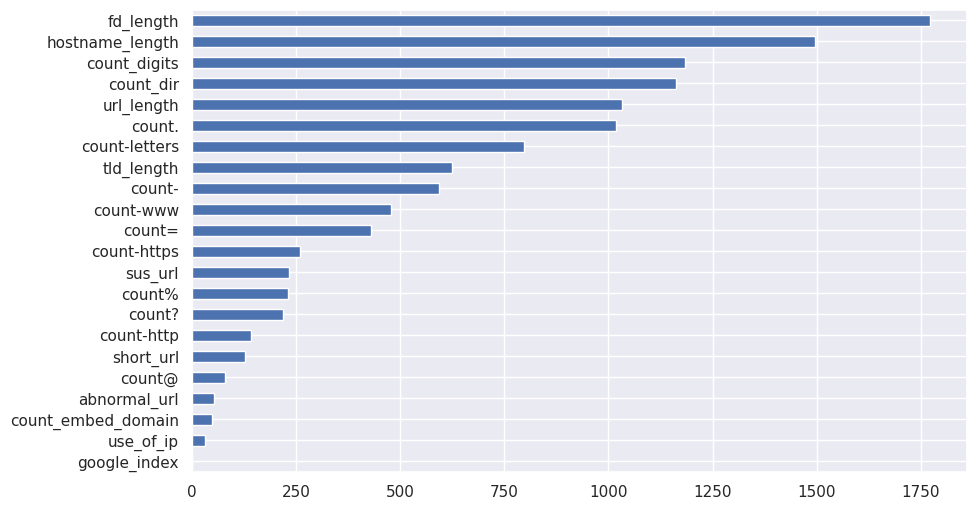

In [ ]:
feat_importances = pd.Series(lgb.feature_importances_, index=X_train.columns)
feat_importances.sort_values().plot(kind="barh",figsize=(10, 6))

XGBOOST CLASSIFIER

In [ ]:
xgb_c = xgb.XGBClassifier(n_estimators= 100)
xgb_c.fit(X_train,y_train)
y_pred_x = xgb_c.predict(X_test)
print(classification_report(y_test,y_pred_x,target_names=['benign', 'defacement','phishing','malware']))


score = metrics.accuracy_score(y_test, y_pred_x)
print("accuracy:   %0.3f" % score)

              precision    recall  f1-score   support

      benign       0.97      0.99      0.98     85621
  defacement       0.97      0.99      0.98     19292
    phishing       0.97      0.91      0.94      6504
     malware       0.91      0.83      0.87     18822

    accuracy                           0.96    130239
   macro avg       0.96      0.93      0.94    130239
weighted avg       0.96      0.96      0.96    130239

accuracy:   0.961


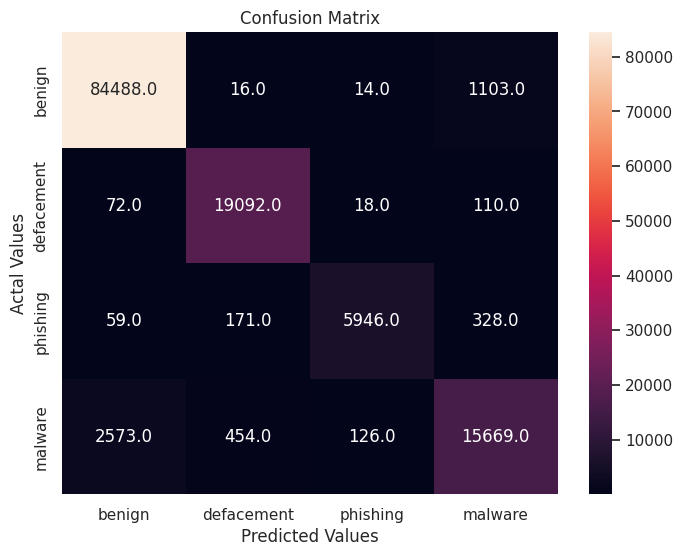

In [ ]:
cm = confusion_matrix(y_test, y_pred_x)
cm_df = pd.DataFrame(cm,
                     index = ['benign', 'defacement','phishing','malware'],
                     columns = ['benign', 'defacement','phishing','malware'])
plt.figure(figsize=(8,6))
sns.heatmap(cm_df, annot=True,fmt=".1f")
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

<Axes: >

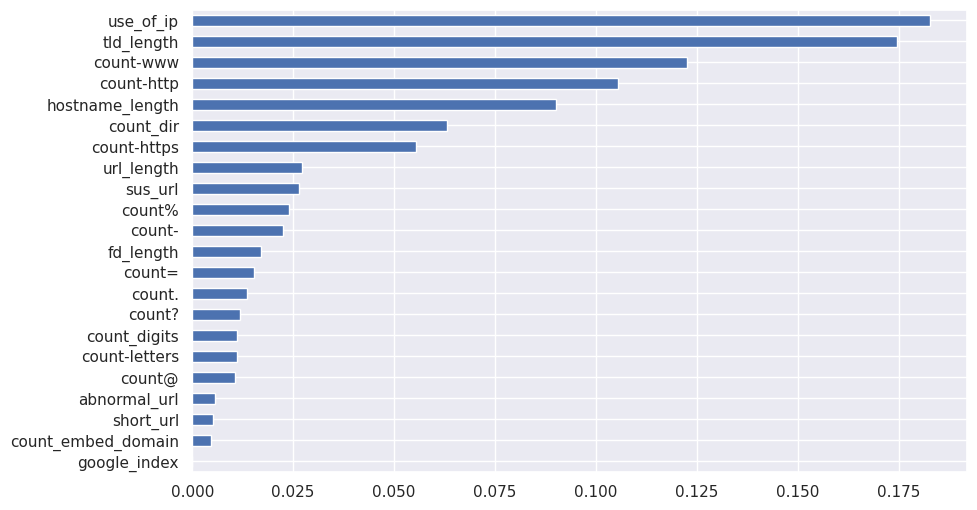

In [ ]:
feat_importances = pd.Series(xgb_c.feature_importances_, index=X_train.columns)
feat_importances.sort_values().plot(kind="barh",figsize=(10, 6))

In [ ]:
def main(url):

    status = []

    status.append(having_ip_address(url))
    status.append(abnormal_url(url))
    status.append(count_dot(url))
    status.append(count_www(url))
    status.append(count_atrate(url))
    status.append(no_of_dir(url))
    status.append(no_of_embed(url))

    status.append(shortening_service(url))
    status.append(count_https(url))
    status.append(count_http(url))

    status.append(count_per(url))
    status.append(count_ques(url))
    status.append(count_hyphen(url))
    status.append(count_equal(url))

    status.append(url_length(url))
    status.append(hostname_length(url))
    status.append(suspicious_words(url))
    status.append(digit_count(url))
    status.append(letter_count(url))
    status.append(fd_length(url))
    tld = get_tld(url,fail_silently=True)

    status.append(tld_length(tld))




    return status

In [ ]:
def get_prediction_from_url(test_url):
    features_test = main(test_url)

    features_test = np.array(features_test).reshape((1, -1))



    pred = lgb.predict(features_test)
    if int(pred[0]) == 0:

        res="SAFE"
        return res
    elif int(pred[0]) == 1.0:

        res="DEFACEMENT"
        return res
    elif int(pred[0]) == 2.0:
        res="PHISHING"
        return res

    elif int(pred[0]) == 3.0:

        res="MALWARE"
        return res


In [ ]:
urls = input("Enter the Url: ")
for url in urls:
     print(get_prediction_from_url(urls))

Enter the Url: www.google.com


ValueError: ignored